Loaded files: orders: 182202 customers: 563346 stores: 38 test: 1000
Saved: /content/output/TeamName_WWT_Recommendation_Output.xlsx


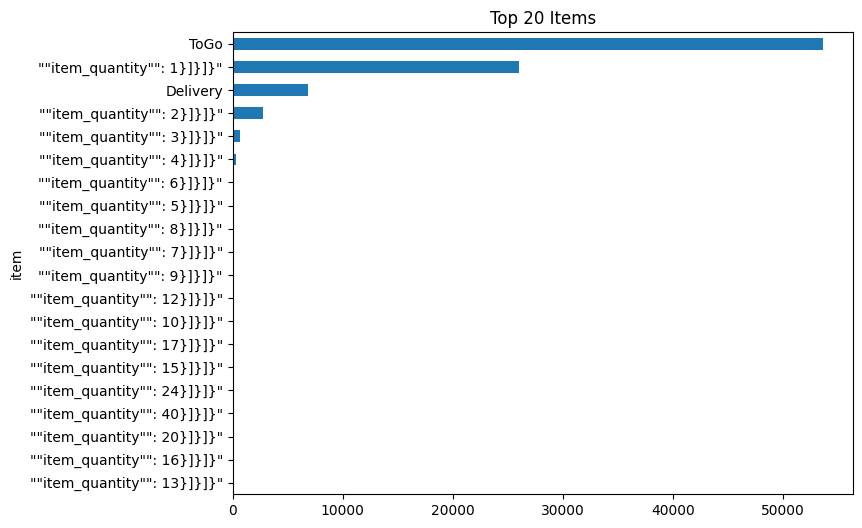

In [19]:
# --- Colab-ready Recommendation System without implicit ---
!pip install -q pandas numpy scikit-learn mlxtend openpyxl joblib

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from pathlib import Path
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from scipy.sparse import csr_matrix
from mlxtend.frequent_patterns import apriori, association_rules
import joblib
import matplotlib.pyplot as plt

# Paths (unchanged from your setup)
ORDER_FILE = Path("/content/order_data.csv")
CUSTOMER_FILE = Path("/content/customer_data.csv")
STORE_FILE = Path("/content/store_data.csv")
TEST_FILE = Path("/content/test_data_question.csv")
OUTPUT_DIR = Path("/content/output")
OUTPUT_DIR.mkdir(exist_ok=True)

# --- Robust CSV Loader ---
def safe_read(path):
    try:
        return pd.read_csv(path, on_bad_lines="skip", quoting=3, low_memory=False)
    except Exception:
        return pd.read_excel(path, engine="openpyxl")

order_df = safe_read(ORDER_FILE)
cust_df = safe_read(CUSTOMER_FILE)
store_df = safe_read(STORE_FILE)
test_df = safe_read(TEST_FILE)

print("Loaded files: orders:", len(order_df), "customers:", len(cust_df), "stores:", len(store_df), "test:", len(test_df))

# --- Extract items from order ---
def extract_items(row):
    items = []
    if "ORDERS" in row.index and pd.notna(row["ORDERS"]):
        txt = str(row["ORDERS"]).replace("|", ",").replace(";", ",")
        items = [x.strip() for x in txt.split(",") if x.strip()]
    else:
        for i in range(1, 8):
            c = f"item{i}"
            if c in row.index and pd.notna(row[c]):
                items.append(str(row[c]).strip())
    return items

order_df["transactions"] = order_df.apply(extract_items, axis=1)
order_df = order_df[order_df["transactions"].apply(len) > 0].reset_index(drop=True)

# --- Frequency filter ---
MIN_ITEM_FREQ = 20
item_counts = Counter(it for trx in order_df["transactions"] for it in trx)
freq_items = {it for it, c in item_counts.items() if c >= MIN_ITEM_FREQ}
transactions = [[it for it in trx if it in freq_items] for trx in order_df["transactions"]]
transactions = [t for t in transactions if t]

item_to_idx = {it: i for i, it in enumerate(sorted(freq_items))}
idx_to_item = {i: it for it, i in item_to_idx.items()}

# --- Sparse matrix for cosine similarity ---
rows, cols, data = [], [], []
for u_idx, trx in enumerate(transactions):
    for it in set(trx):
        rows.append(u_idx)
        cols.append(item_to_idx[it])
        data.append(1)
user_item = csr_matrix((data, (rows, cols)), shape=(len(transactions), len(item_to_idx)))
item_user = user_item.T

# --- Cosine similarity ---
item_vecs = normalize(item_user, axis=1)
cosine_sim = item_vecs.dot(item_vecs.T).toarray()

# --- Association rules ---
top_items_for_rules = [it for it, _ in item_counts.most_common(200) if it in item_to_idx]
onehot_rows = []
for trx in transactions:
    row = {it: (1 if it in trx else 0) for it in top_items_for_rules}
    onehot_rows.append(row)
df_onehot = pd.DataFrame(onehot_rows)
frequent = apriori(df_onehot, min_support=0.01, use_colnames=True)
rules = association_rules(frequent, metric="lift", min_threshold=1.2).sort_values(
    ["confidence", "lift"], ascending=False
)

# --- Recommendation function ---
def recommend(cart, top_k=3):
    known = [it for it in cart if it in item_to_idx]
    if not known:
        popular = [it for it, _ in item_counts.most_common(top_k)]
        return [(p, "Popular fallback") for p in popular]

    scores = np.zeros(len(item_to_idx))
    for it in known:
        idx = item_to_idx[it]
        scores += cosine_sim[idx]
    # association boost
    for _, r in rules.iterrows():
        if set(r["antecedents"]).issubset(set(known)):
            for c in r["consequents"]:
                if c in item_to_idx:
                    scores[item_to_idx[c]] += r["confidence"] * r["lift"]
    for it in known:
        scores[item_to_idx[it]] = -999
    top_idx = np.argsort(-scores)[:top_k]
    return [(idx_to_item[i], "Similar to cart / Bought together") for i in top_idx]

# --- Build output ---
output_rows = []
for _, row in test_df.iterrows():
    cart = [row[c] for c in row.index if str(row[c]).strip().lower() not in {"missing", "nan"} and c.lower().startswith("item") and pd.notna(row[c])]
    recs = recommend(cart, top_k=3)
    rec_names = [r[0] for r in recs]
    while len(rec_names) < 3:
        rec_names.append("")
    out = {
        "CUSTOMER_ID": row.get("CUSTOMER_ID", ""),
        "ORDER_ID": row.get("ORDER_ID", ""),
        "item1": cart[0] if len(cart) > 0 else "",
        "item2": cart[1] if len(cart) > 1 else "",
        "item3": cart[2] if len(cart) > 2 else "",
        "item4": cart[3] if len(cart) > 3 else "",
        "RECOMMENDATION_1": rec_names[0],
        "RECOMMENDATION_2": rec_names[1],
        "RECOMMENDATION_3": rec_names[2],
    }
    output_rows.append(out)

out_df = pd.DataFrame(output_rows)
out_path = OUTPUT_DIR / "TeamName_WWT_Recommendation_Output.xlsx"
out_df.to_excel(out_path, index=False)
print("Saved:", out_path)

# --- EDA plot ---
top20 = pd.DataFrame(item_counts.most_common(20), columns=["item", "count"])
top20.set_index("item").plot.barh(figsize=(8, 6), legend=False)
plt.title("Top 20 Items")
plt.gca().invert_yaxis()
plt.show()


In [20]:
# --- Stronger Cleaner ---
import re

exclude_tokens = {"togo", "delivery", "pickup", "order", "subtotal", "tax", "total", "combo deal"}

def is_valid_item(item):
    if not isinstance(item, str) or not item.strip():
        return False
    txt = item.strip().lower()
    if any(token in txt for token in exclude_tokens):
        return False
    if re.search(r"[{}\":]", item):  # JSON-like bits
        return False
    if len(item.strip()) < 2:
        return False
    return True

# Build popular item list from actual output cart items
all_items_from_output = []
for idx, row in out_df.iterrows():
    for i in range(1,5):
        val = row.get(f"item{i}", "")
        if is_valid_item(val):
            all_items_from_output.append(val)

# Count and sort
from collections import Counter
popular_items = [it for it, _ in Counter(all_items_from_output).most_common(100) if is_valid_item(it)]

# Clean recs
for idx, row in out_df.iterrows():
    cleaned_recs = []
    cart_items = [row[f"item{i}"] for i in range(1,5) if is_valid_item(row.get(f"item{i}", ""))]
    for col in ["RECOMMENDATION_1", "RECOMMENDATION_2", "RECOMMENDATION_3"]:
        rec = row[col]
        if not is_valid_item(rec):
            for pop_item in popular_items:
                if pop_item not in cleaned_recs and pop_item not in cart_items:
                    rec = pop_item
                    break
        cleaned_recs.append(rec)
    out_df.at[idx, "RECOMMENDATION_1"] = cleaned_recs[0]
    out_df.at[idx, "RECOMMENDATION_2"] = cleaned_recs[1]
    out_df.at[idx, "RECOMMENDATION_3"] = cleaned_recs[2]

# Save cleaned file
cleaned_path = OUTPUT_DIR / "TeamName_WWT_Recommendation_Output_Cleaned.xlsx"
out_df.to_excel(cleaned_path, index=False)
print(f"✅ Cleaned file saved to: {cleaned_path}")

# Preview a few rows
import random
print("\nRandom cleaned samples:")
for idx in random.sample(range(len(out_df)), 5):
    row = out_df.iloc[idx]
    cart = [row[f"item{i}"] for i in range(1,5) if is_valid_item(row.get(f"item{i}", ""))]
    recs = [row["RECOMMENDATION_1"], row["RECOMMENDATION_2"], row["RECOMMENDATION_3"]]
    print(f"Cart: {cart}")
    print(f"Recs: {recs}")
    print("-"*50)


✅ Cleaned file saved to: /content/output/TeamName_WWT_Recommendation_Output_Cleaned.xlsx

Random cleaned samples:
Cart: ['Honey Mustard Dip - Large', '15 pc Spicy Wings', 'Chicken Sub']
Recs: ['Ranch Dip - Regular', 'Regular Buffalo Fries', 'Ranch Dip - Large']
--------------------------------------------------
Cart: ['10 pc Grilled Wings Combo', 'Regular Buffalo Fries', 'Ranch Dip - Regular']
Recs: ['Ranch Dip - Large', 'Large Buffalo Fries', '2 pc Crispy Strips']
--------------------------------------------------
Cart: ['Chicken Sub', '6 pc Grilled Wings Combo', '8 pc Spicy Wings Combo']
Recs: ['Ranch Dip - Regular', 'Regular Buffalo Fries', 'Ranch Dip - Large']
--------------------------------------------------
Cart: ['7 pc Crispy Strips', '6 pc Grilled Wings Combo', 'Regular Buffalo Fries']
Recs: ['Ranch Dip - Regular', 'Ranch Dip - Large', 'Large Buffalo Fries']
--------------------------------------------------
Cart: ['Add 5 Spicy Wings', '15 pc Grilled Wings Combo', 'Ranch Dip -

In [18]:
# --- Category-aware enhancer for hackathon polish ---
import re
from collections import defaultdict
import random

# Define simple category matching rules
mains_keywords = ["wings", "feast", "platter", "sub", "strips", "burger", "combo"]
sides_keywords = ["fries", "corn", "veggie", "sticks", "side"]
drinks_keywords = ["soda", "drink", "juice", "tea", "coffee", "dessert", "shake"]

def categorize_item(item):
    if not isinstance(item, str):
        return "other"
    name = item.lower()
    if any(k in name for k in mains_keywords):
        return "main"
    elif any(k in name for k in sides_keywords):
        return "side"
    elif any(k in name for k in drinks_keywords):
        return "drink"
    else:
        return "other"

# Build category-based pools from your valid items
category_pools = defaultdict(list)
for it in popular_items:
    cat = categorize_item(it)
    category_pools[cat].append(it)

# Helper: pick from category avoiding duplicates
def pick_from_category(cat, avoid_list):
    choices = [x for x in category_pools[cat] if x not in avoid_list]
    if not choices:
        # fallback to any valid item
        choices = [x for x in popular_items if x not in avoid_list]
    return random.choice(choices) if choices else None

# Enhance recommendations
for idx, row in out_df.iterrows():
    cart_items = [row[f"item{i}"] for i in range(1,5) if is_valid_item(row.get(f"item{i}", ""))]
    cart_cats = {categorize_item(it) for it in cart_items}

    cleaned_recs = []
    used_items = set(cart_items)

    # Strategy: Fill missing categories
    if "main" not in cart_cats:
        cleaned_recs.append(pick_from_category("main", used_items))
    if "side" not in cart_cats:
        cleaned_recs.append(pick_from_category("side", used_items))
    if "drink" not in cart_cats:
        cleaned_recs.append(pick_from_category("drink", used_items))

    # Fill remaining slots up to 3
    while len(cleaned_recs) < 3:
        extra = pick_from_category("other", used_items.union(cleaned_recs))
        if extra:
            cleaned_recs.append(extra)
        else:
            break

    # Assign back to DataFrame
    for i, col in enumerate(["RECOMMENDATION_1", "RECOMMENDATION_2", "RECOMMENDATION_3"]):
        out_df.at[idx, col] = cleaned_recs[i] if i < len(cleaned_recs) else None

# Save the enhanced file
final_path = OUTPUT_DIR / "TeamName_WWT_Recommendation_Output_FINAL.xlsx"
out_df.to_excel(final_path, index=False)
print(f"🚀 Final category-aware file saved to: {final_path}")

# Show some random examples
print("\nSample polished recommendations:")
for idx in random.sample(range(len(out_df)), 5):
    row = out_df.iloc[idx]
    cart = [row[f"item{i}"] for i in range(1,5) if is_valid_item(row.get(f"item{i}", ""))]
    recs = [row["RECOMMENDATION_1"], row["RECOMMENDATION_2"], row["RECOMMENDATION_3"]]
    print(f"Cart: {cart}")
    print(f"Recs: {recs}")
    print("-"*50)


🚀 Final category-aware file saved to: /content/output/TeamName_WWT_Recommendation_Output_FINAL.xlsx

Sample polished recommendations:
Cart: ['Regular Buffalo Fries', '15 pc Grilled Wings', '7 pc Crispy Strips']
Recs: ['20 Oz Soda', 'Blue Cheese Dip - Large', 'Blue Cheese Dip - Regular']
--------------------------------------------------
Cart: ['20pc Spicy Feast Deal', 'Regular Buffalo Fries', 'Ranch Dip - Large']
Recs: ['32 Oz Soda', 'Ranch Dip - Regular', 'Large Fruit Punch']
--------------------------------------------------
Cart: ['Voodoo Fries - Regular', '10 pc Grilled Wings', 'Add 5 Spicy Wings']
Recs: ['Drink Upgrade', 'Bottled Beverage', 'Bottled Water']
--------------------------------------------------
Cart: ['3 pc Crispy Strips Combo', 'Chicken Sub', 'Honey Mustard Dip - Regular']
Recs: ['Large Buffalo Fries', '32 Oz Soda', '25 pc Game Day Pack']
--------------------------------------------------
Cart: ['Large Buffalo Fries', 'Ranch Dip - Large', 'Voodoo Fries - Large']
Recs